Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cd /content/drive/MyDrive/cs674/project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-05-22 03:57:51.647896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 03:57:51.647972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 03:57:51.650092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 03:57:51.669364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 03:57:56.134785: W tensorflow/comp

## Setup imports

In [3]:
import os
import shutil
import tempfile
import time
import random
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch
import torch.nn as nn
import torch.nn.functional as F

print_config()

MONAI version: 1.4.dev2420
Numpy version: 1.25.2
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4af7b3fbfa2fa119c6b7408d00bbe174ebda42bf
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

# set directory once it exists to avoid redownloading
os.environ["MONAI_DATA_DIRECTORY"] = root_dir

model_dir = "/content/drive/MyDrive/custom-sam-3d/project/models/"

/tmp/tmpriywzvm1


## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [6]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [7]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [9]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=2
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=2
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

Task01_BrainTumour.tar: 7.09GB [06:38, 19.1MB/s]                            

2024-05-22 04:13:21,474 - INFO - Downloaded: /tmp/tmpriywzvm1/Task01_BrainTumour.tar


2024-05-22 04:13:55,297 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-05-22 04:13:55,300 - INFO - Writing into directory: /tmp/tmpriywzvm1.


## Check data shape and visualize

image shape: torch.Size([4, 224, 224, 144])


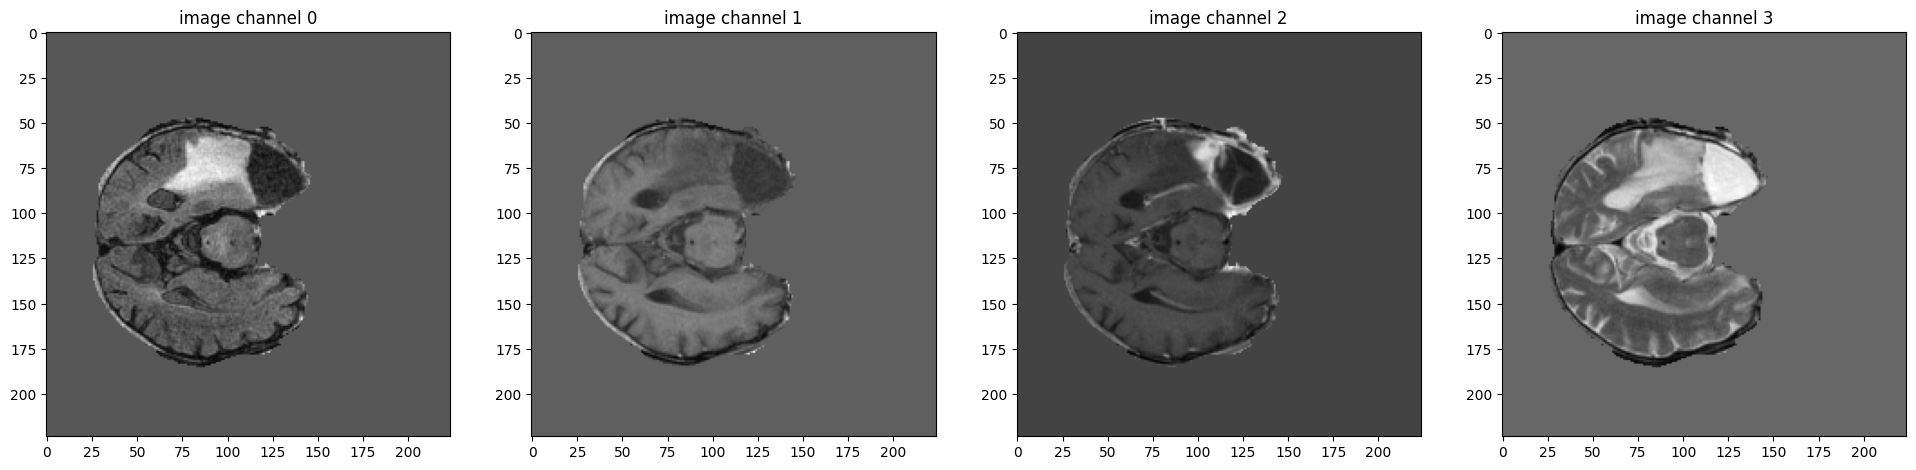

label shape: torch.Size([3, 224, 224, 144])


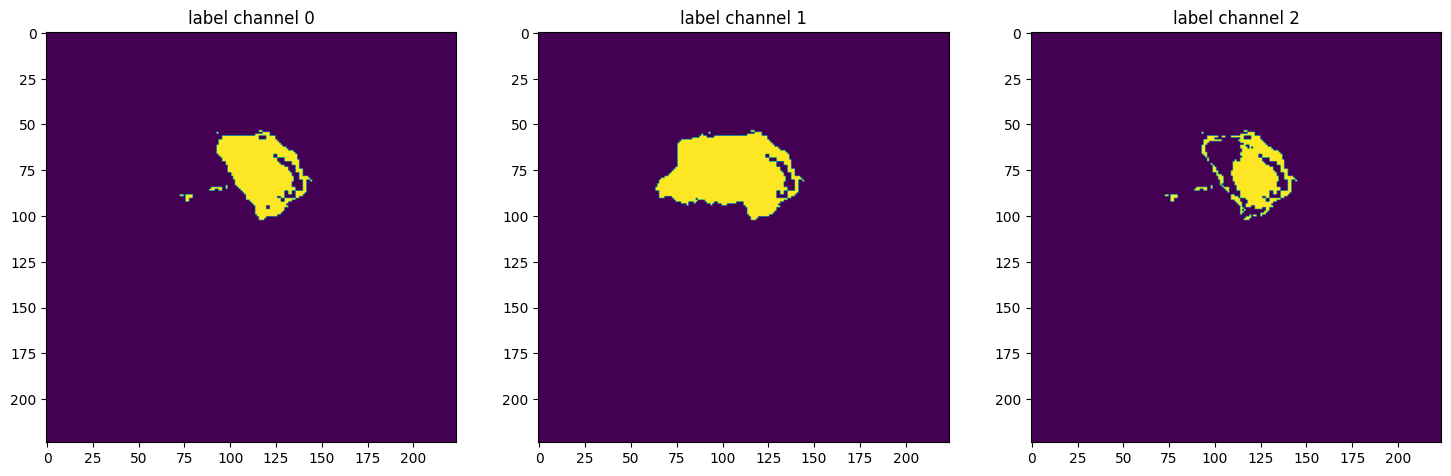

In [10]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
N = len(val_ds)
# extra random call so below example has a tumor
random.randint(0,N-1)
val_data_example = val_ds[random.randint(0,N-1)]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [11]:
device = torch.device("cuda:0")

import torchvision.models

# Define Slice Encoder
# Expects input shape [N, C, H, W] = [N, 4, 224, 224]
class Slice_Encoder(nn.Module) :
    def __init__(self, in_channels=4, kernel_size=5) :
        super(Slice_Encoder, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size

        self.conv1 = nn.Conv2d(in_channels, 32, self.kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2, 0) # [112, 112]

        self.conv2 = nn.Conv2d(32, 64, self.kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2, 0) # [56, 56]

        self.conv3 = nn.Conv2d(64, 128, self.kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2, 0) # [28, 28]

        self.conv4 = nn.Conv2d(128, 256, self.kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        # FEATURE ENCODER --> NO FINAL LINEAR LAYER

    def forward(self, x, N) :
        D = x.shape[0]//N
        C = x.shape[1]
        H = x.shape[2]
        W = x.shape[3]

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        skip_1 = x.reshape(N, D, 32, H//2, W//2).transpose(1,2)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        skip_2 = x.reshape(N, D, 64, H//4, W//4).transpose(1,2)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        skip_3 = x.reshape(N, D, 128, H//8, W//8).transpose(1,2)

        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu4(x)

        return x, [skip_1, skip_2, skip_3]

# Define volume decoder
# Expects input shape [N, C, D, H, W] = [N, 512, 144, 28, 28]
class Volume_Decoder(nn.Module) :
    def __init__(self, out_channels=3, kernel_size=5) :
        super(Volume_Decoder, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.conv0 = nn.Conv3d(256, 128, kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm0 = nn.InstanceNorm3d(128)
        self.relu0 = nn.LeakyReLU()

        self.conv1 = nn.Conv3d(256, 64, kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm1 = nn.InstanceNorm3d(64)
        self.relu1 = nn.LeakyReLU()
        self.usmp1 = nn.Upsample([144, 56, 56])

        self.conv2 = nn.Conv3d(128, 32, kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm2 = nn.InstanceNorm3d(32)
        self.relu2 = nn.LeakyReLU()
        self.usmp2 = nn.Upsample([144, 112, 112])

        self.conv3 = nn.Conv3d(64, 16, kernel_size, 1, 'same', bias=False, padding_mode='reflect')
        self.norm3 = nn.InstanceNorm3d(16)
        self.relu3 = nn.LeakyReLU()
        self.usmp3 = nn.Upsample([144, 224, 224])

        self.final_conv = nn.Conv3d(16, self.out_channels, kernel_size, 1, 'same', bias=True, padding_mode='reflect')

    def forward(self, x, skip_connections) :
        skip_1, skip_2, skip_3 = skip_connections

        x = self.conv0(x)
        x = self.norm0(x)
        x = self.relu0(x)

        x = torch.cat((x,skip_3), 1)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.usmp1(x)

        x = torch.cat((x, skip_2), 1)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.usmp2(x)

        x = torch.cat((x, skip_1), 1)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.usmp3(x)

        x = self.final_conv(x)

        return x

# Define custom SAM3D model
class Custom_SAM3D_RPH(nn.Module) :
    def __init__(self, in_channels, out_channels, kernel_size=5) :
        super(Custom_SAM3D_RPH, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        #2D Encoder to use
        self.slice_encoder = Slice_Encoder(in_channels, kernel_size)

        #3D Decoder to use
        self.volume_decoder = Volume_Decoder(out_channels, kernel_size)

    def forward(self, x) :
        #get input shapes
        N = x.shape[0]
        C = x.shape[1]
        D = x.shape[2]
        H = x.shape[3]
        W = x.shape[4]
        # [N, C, D, H, W]

        # reshape for slice encoder
        x = x.transpose(1,2) # [N, D, C, H, W]
        x = x.reshape(-1, C, H, W) # [N*D, C, H, W]

        # pass to slice encoder
        x, skip_connections = self.slice_encoder(x, N) # [N*D, 256, H/8, W/8]

        # reshape for volume decoder
        newC = x.shape[1]
        newH = x.shape[2]
        newW = x.shape[3]
        x = x.reshape(N, D, newC, newH, newW) # [N, D, 256, H/8, W/8]

        x = x.transpose(1,2) # [N, 256, D, H/8, W/8]

        # pass to volume decoder
        x = self.volume_decoder(x, skip_connections) #[N, 3, D, H, W]
        return x

In [12]:
max_epochs = 10
val_interval = 1
VAL_AMP = True
device = torch.device("cuda:0")

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
# model = SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=4,
#     out_channels=3,
#     dropout_prob=0.2,
# ).to(device)
model = Custom_SAM3D_RPH(in_channels=4, out_channels=3, kernel_size=5).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

#load saved checkpoint to continue training
load_prev_checkpoint = True
checkpoint_path = os.path.join(model_dir, "custom_SAM3D_checkpoint.pth")
best_model_path = os.path.join(model_dir, "best_custom_SAM3D_model.pth")
if load_prev_checkpoint and os.path.isfile(checkpoint_path):
    print("loading previous checkpointed model/optimizer/lr_scheduler states")
    loaded_checkpoint = torch.load(checkpoint_path)
    resume_at_epoch = loaded_checkpoint['epoch']
    model.load_state_dict(loaded_checkpoint['model_state_dict'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
    lr_scheduler = loaded_checkpoint['lr_scheduler']

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(144, 224, 224),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

loading previous checkpointed model/optimizer/lr_scheduler states


## Execute a typical PyTorch training process

In [13]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

#metric values from previous run (10 epochs)
best_metric = 0.7285696864128113
best_metric_epoch = 9
epoch_loss_values = [0.4245291825806357, 0.29490907963595747, 0.26854376401752234, 0.2598193432348444, 0.24971528114155703, 0.23930687343068036, 0.2280330228206423, 0.22226193890013954, 0.21629345961414354, 0.2130637174549023]
metric_values = [0.620644211769104, 0.6760085225105286, 0.6882061958312988, 0.7085313200950623, 0.7071207165718079, 0.7163048386573792, 0.7023603320121765, 0.7239769101142883, 0.7285696864128113, 0.7174298167228699]
metric_values_tc = [0.6616539359092712, 0.7300984263420105, 0.748702347278595, 0.7576033473014832, 0.7606642842292786, 0.7670573592185974, 0.7611851692199707, 0.77325040102005, 0.7793567776679993, 0.7677872776985168]
metric_values_wt = [0.8051118850708008, 0.8380365967750549, 0.8296723961830139, 0.8631194233894348, 0.8596765398979187, 0.8722255229949951, 0.8544804453849792, 0.8804600238800049, 0.8810942769050598, 0.8749384880065918]
metric_values_et = [0.3951667845249176, 0.4598905146121979, 0.4862436354160309, 0.504871129989624, 0.5010214447975159, 0.5096318125724792, 0.49141553044319153, 0.5182203054428101, 0.5252577662467957, 0.5095638036727905]

total_start = time.time()
# start from last epoch
# if first time, starts from 0
for epoch in range(len(epoch_loss_values), max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # inputs shape (N, C, H, W, D): (1, 4, 224, 224, 144)
        inputs = inputs.permute(0, 1, 4, 2, 3) # now (N, C, D, H, W) for torch
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            outputs = outputs.permute(0, 1, 3, 4, 2) # now (N, C, H, W, D) for MONAI
            loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        epoch_loss += loss.item()
        if step % 10 == 0 :
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_inputs = val_inputs.permute(0, 1, 4, 2, 3) # now (N, C, D, H, W) for torch
                val_outputs = inference(val_inputs)
                val_outputs = val_outputs.permute(0, 1, 3, 4, 2) # now (N, C, H, W, D) for MONAI
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(model.state_dict(), best_model_path)
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    # print plot statistics
    print("epoch_loss_values:", epoch_loss_values)
    print("metric_values:", metric_values)
    print("metric_values_tc:", metric_values_tc)
    print("metric_values_wt:", metric_values_wt)
    print("metric_values_et:", metric_values_et)
    # save training checkpoint
    torch.save(
        {'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler},
        checkpoint_path)
    print("saved training checkpoint for epoch", epoch+1)
total_time = time.time() - total_start

In [14]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7286 at epoch: 9, total time: 0.0006275177001953125.


## Plot the loss and metric

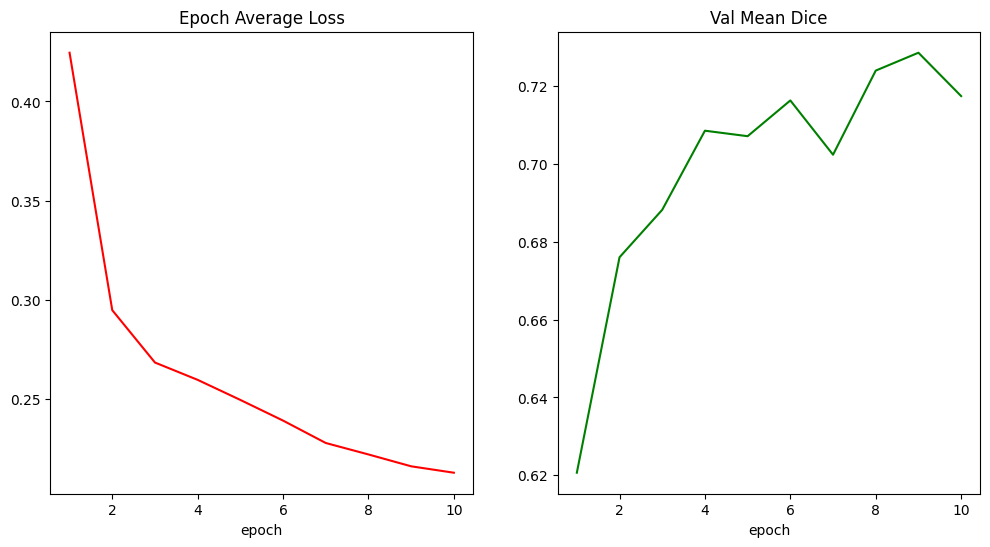

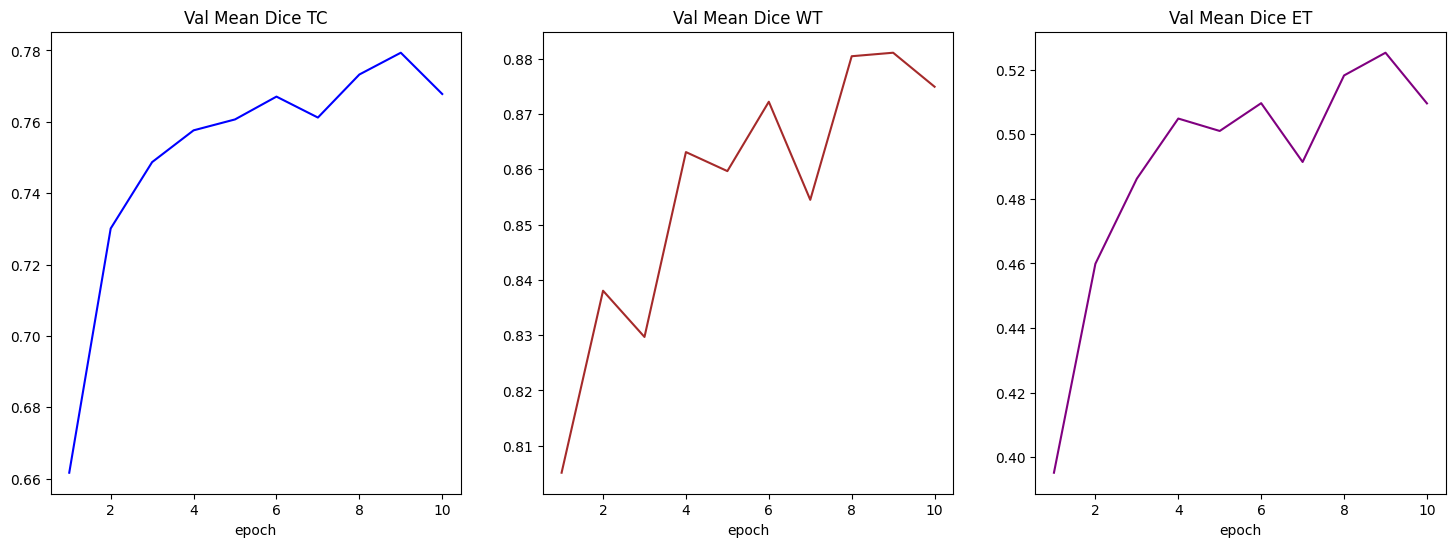

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

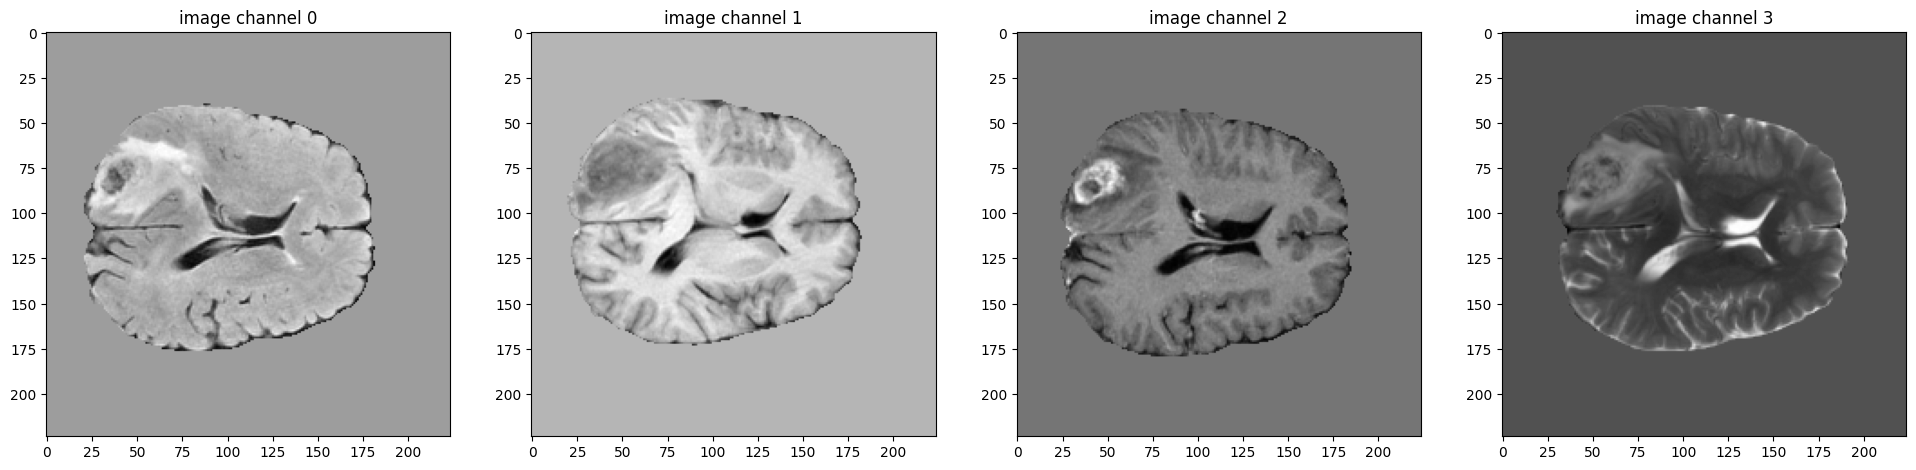

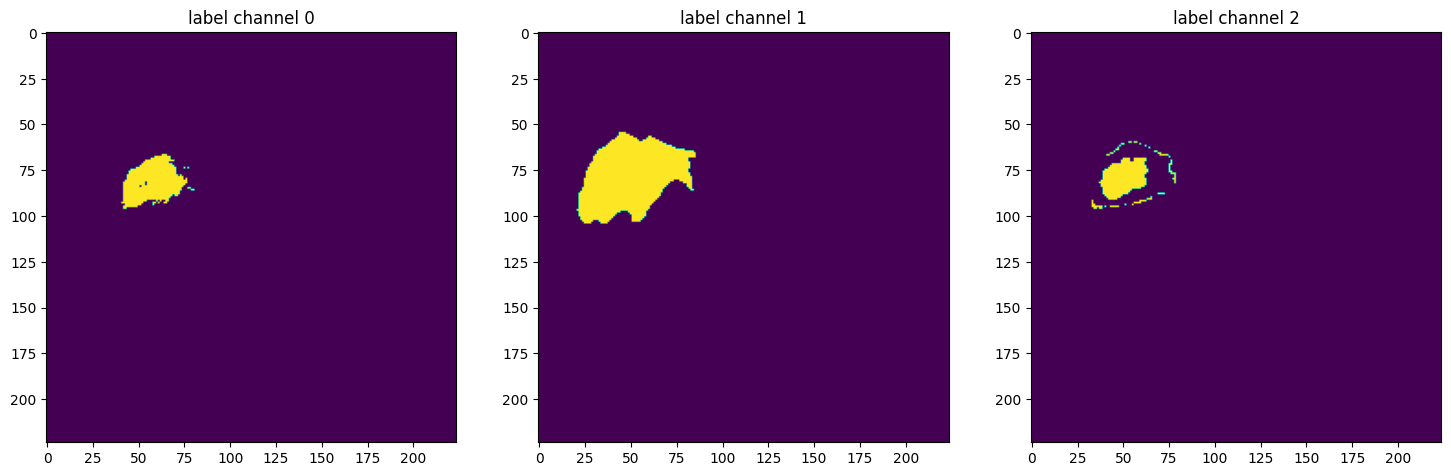

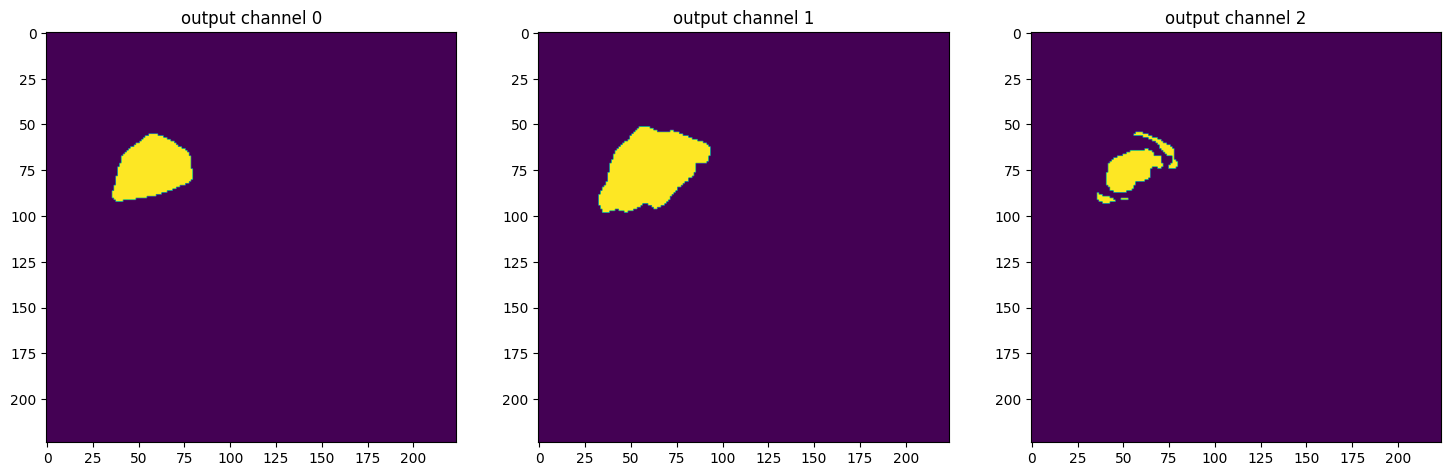

In [22]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    idx = random.randint(0,N-1)
    # select one image to evaluate and visualize the model output
    val_input = val_ds[idx]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[idx]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[idx]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [17]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=2
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=2)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [18]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Metric on original image spacing:  0.7009570598602295
metric_tc: 0.7602
metric_wt: 0.8453
metric_et: 0.4974


## Cleanup data directory

Remove directory if a temporary was used.

In [19]:
# if directory is None:
#     shutil.rmtree(root_dir)

In [20]:
# from google.colab import runtime
# runtime.unassign()